In [1]:
import json 
import os
import numpy as np
import random
from tqdm import tqdm
from pathlib import Path
import math

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

#from sklearn.manifold import TSNE
#from openTSNE import TSNE
import umap.umap_ as umap

import cv2
import matplotlib.pyplot as plt


/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load json file
with open('../dataset-info/imagenet_class_index.json') as f:
    imagenet_class_index_dict = json.load(f)

TARGET_CATEGORIES = ['dog', 'bird', 'insect', 'turtle']
# Restricted Imagenet Range 
# https://github.com/MadryLab/robustness/blob/a9541241defd9972e9334bfcdb804f6aefe24dc7/robustness/tools/constants.py#L7
# dog (117), cat (5), frog (3), turtle (5), bird (21), 
# monkey (14), fish (9), crab (4), insect (20) 
RESTRICTED_IMAGNET_RANGES = [(151, 267), (281, 285), 
        (30, 32), (33, 37), (80, 100), (365, 382),
          (389, 397), (118, 121), (300, 319)]

CLASS2LABEL = {-1: 'noise', 0: 'dog', 1: 'cat', 
        2: 'frog', 3: 'turtle', 4: 'bird', 
        5: 'primate', 6: 'fish', 7: 'crab', 
        8: 'insect'}

LABEL2CLASS= dict((v,k) for k,v in CLASS2LABEL.items())

In [3]:
# Check if GPU is available; otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50 model and remove the final fully connected layer
model = models.resnet50(pretrained=True)
# Remove the last fully connected layer to get the 2048-d features
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device)
model.eval()

# Define transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# plot umap emedding of validation dataset

In [4]:
# get target synset and label
# dogs, birds, turtles, and insects 
DIR_SOURCE_TRAIN = Path('/data/datasets/imagenet/train')
DIR_SOURCE_VAL = Path('/data/datasets/imagenet/val')

def get_target_imagepathlist(dir_sourceimg):
    print('Source Image Directory:', dir_sourceimg)
    d_imagepathlist= {}
    for target in TARGET_CATEGORIES:
        d_imagepathlist[target] = {}
        target_range = RESTRICTED_IMAGNET_RANGES[LABEL2CLASS[target]]
        target_synset = []
        #target_synset_label = []
        for i in range(target_range[0],target_range[1]+1):
            synset, label = imagenet_class_index_dict[str(i)]
            target_synset.append(synset)
            #target_synset_label.append(label)

        print(target, "# synsets: ", len(target_synset))
        
        imagelist = []
        # get imagelist for target
        for synset in target_synset:
            path_synset = dir_sourceimg/synset
            imagelist.extend([path_synset/imagename for imagename in os.listdir(path_synset)])
            
        print('# of images', len(imagelist))
        d_imagepathlist[target] = imagelist #[DIR_SOURCEIMG/synset/imagename for imagename in imagelist]

    return d_imagepathlist

d_imagepathlist_train = get_target_imagepathlist(DIR_SOURCE_TRAIN)
d_imagepathlist_val = get_target_imagepathlist(DIR_SOURCE_VAL)


Source Image Directory: /data/datasets/imagenet/train
dog # synsets:  117
# of images 147118
bird # synsets:  21
# of images 27141
insect # synsets:  20
# of images 26000
turtle # synsets:  5
# of images 6500
Source Image Directory: /data/datasets/imagenet/val
dog # synsets:  117
# of images 5850
bird # synsets:  21
# of images 1050
insect # synsets:  20
# of images 1000
turtle # synsets:  5
# of images 250


In [5]:
d_imagepathlist= d_imagepathlist_val
all_features = []
all_labels = []
for label in TARGET_CATEGORIES:
    for img_path in tqdm(d_imagepathlist[label], desc=f"Processing {label}", leave=True):
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        img_tensor = transform(img).unsqueeze(0).to(device)
            
        # Forward pass through the network
        with torch.no_grad():
            feature = model(img_tensor)
        # Flatten the feature (from shape [1, 2048, 1, 1] to [2048])
        feature = feature.view(feature.size(0), -1).cpu().numpy().squeeze()
        
        all_features.append(feature)
        all_labels.append(label)

all_features = np.array(all_features)
print("features shape", all_features.shape)

Processing turtle: 100%|██████████| 250/250 [00:02<00:00, 90.20it/s]

features shape (8150, 2048)


In [6]:
# --- UMAP Embedding ---
umap_embedder = umap.UMAP(n_neighbors=200, min_dist=0.7, n_components=2, random_state=42)
umap_results = umap_embedder.fit_transform(all_features)

# --- Compute Category Centers in UMAP Space ---
category_centers = {}
for label in TARGET_CATEGORIES:
    idxs = [i for i, l in enumerate(all_labels) if l == label]
    category_centers[label] = np.mean(umap_results[idxs], axis=0)


/home/young/anaconda3/envs/wormholes/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


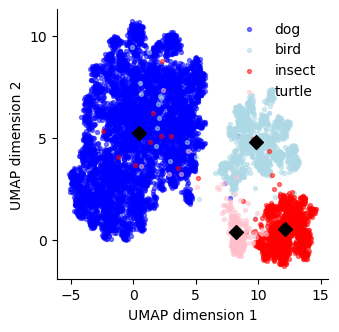

In [14]:
# Define cluster colors in the same order as your TARGET_CATEGORIES
cluster_colors = ['blue', 'lightblue', 'red', 'pink']  # 'light red' replaced by 'lightcoral'

# --- Visualization ---
plt.style.use('default')
plt.figure(figsize=(3.5, 3.5))

# Plot original UMAP embeddings by category with specified cluster colors
for label, color in zip(TARGET_CATEGORIES, cluster_colors):
    idxs = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(umap_results[idxs, 0], umap_results[idxs, 1],
                label=f"{label}", s=8, alpha=0.5, color=color)

# Plot category centers
for label, center in category_centers.items():
    plt.scatter(center[0], center[1], marker='D', s=50, color='black')

plt.legend(fontsize=10, frameon=False)
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.locator_params(axis='both', nbins=5)

# Save the figure as an SVG file
plt.savefig("../figures/savefig/umap_visualization_2color.png", dpi=300,  bbox_inches='tight')
plt.show()


# obtain template from randomly chosen samples

In [114]:
def get_target_template_features(d_imagepathlist, n_samples, save=False):
    # Process new images 
    d_features_mean_list = {}

    for label in TARGET_CATEGORIES:
        features_mean_list = []
        #new_features_mean_labels = []
        for i in range(10):
            random.seed(42+i)
            d_imagepathlist_sampled = random.sample(d_imagepathlist[label], n_samples)
            
            features = []
            for img_path in tqdm(d_imagepathlist_sampled, desc=f"Processing new {i, label}", leave=False):
                try:
                    img = Image.open(img_path).convert('RGB')
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feature = model(img_tensor)
                feature = feature.view(feature.size(0), -1).cpu().numpy().squeeze()
                features.append(feature)
                
            features_mean = np.mean(np.array(features), axis=0)
            features_mean_list.append(features_mean)
            #new_features_mean_labels.append(label)
        
        features_mean_list = np.array(features_mean_list)
        d_features_mean_list[label] = features_mean_list
    if save:
        save_path = f'../checkpoints/template/d_resnet50_ten_template_features_from{n_samples}.npz'
        print(f"Saving to {save_path}")
        np.savez(save_path, d_features_mean_list)
    #test = np.load(f'../checkpoints/template/d_resnet50_features_mean{N_IMAGES_PER_CATEGORY}.npy', allow_pickle=True).item()
    return d_features_mean_list


for N_IMAGES_PER_CATEGORY in [10, 50, 100, 500, 1000]:
    print(f"Processing {N_IMAGES_PER_CATEGORY} images per category")
    d_new_features_mean_list = get_target_template_features(d_imagepathlist_train, N_IMAGES_PER_CATEGORY, save=True)

    # get distance from the umap center
    d_distance = {}
    for label in TARGET_CATEGORIES:
        d_distance[label] = []
        new_features_mean_list = d_new_features_mean_list[label]
        new_umap_coords = umap_embedder.transform(new_features_mean_list)
        distance_list =[]
        for i, coord in enumerate(new_umap_coords):
            center = category_centers[label]
            distance = np.linalg.norm(coord - center)
            distance_list.append(distance)
            #print(f"New image {i} (label: {label}) is {distance:.2f} units away from its category center.")
        distance_mean = np.mean(distance_list)
        distance_sd = np.std(distance_list)
        d_distance[label] = (distance_mean, distance_sd)

    save_path = f'../checkpoints/template/d_resnet50_ten_template_features_from{N_IMAGES_PER_CATEGORY}_avgdist_from_umapcenter_and_sd.npy'
    print(f"Saving to {save_path}")
    np.save(save_path, d_distance)


Processing 10 images per category


Saving to ../checkpoints/template/d_resnet50_ten_template_features_from10.npz
Saving to ../checkpoints/template/d_resnet50_ten_template_features_from10_avgdist_from_umapcenter_and_sd.npy
Processing 50 images per category


Saving to ../checkpoints/template/d_resnet50_ten_template_features_from50.npz
Saving to ../checkpoints/template/d_resnet50_ten_template_features_from50_avgdist_from_umapcenter_and_sd.npy
Processing 100 images per category


Saving to ../checkpoints/template/d_resnet50_ten_template_features_from100.npz
Saving to ../checkpoints/template/d_resnet50_ten_template_features_from100_avgdist_from_umapcenter_and_sd.npy
Processing 500 images per category


Saving to ../checkpoints/template/d_resnet50_ten_template_features_from500.npz
Saving to ../checkpoints/template/d_resnet50_ten_template_features_from500_avgdist_from_umapcenter_and_sd.npy
Processing 1000 images per category


Saving to ../checkpoints/template/d_resnet50_ten_template_features_from1000.npz
Saving to ../checkpoints/template/d_resnet50_ten_template_features_from1000_avgdist_from_umapcenter_and_sd.npy


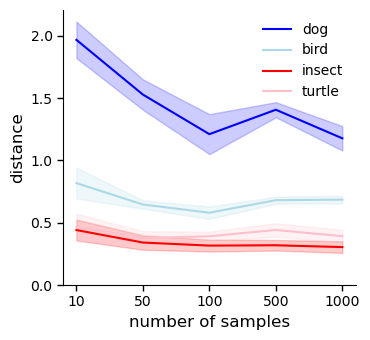

In [3]:
# get distance from the center of each umap category cluster

import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# Set a scientific style with seaborn
#sns.set(style="white", context="paper", font_scale=1.1)
#plt.rcParams["axes.edgecolor"] = "0.2"

# Example sample sizes and file paths
sample_sizes = [10, 50, 100, 500, 1000]
file_names = [f"../checkpoints/template/d_resnet50_ten_template_features_from{s}_avgdist_from_umapcenter_and_sd.npy" for s in sample_sizes]
results = {cat: {"dist": [], "sd": []} for cat in TARGET_CATEGORIES}

# Load data from each file
for file in file_names:
    data = np.load(file, allow_pickle=True).item()
    for cat in TARGET_CATEGORIES:
        dist, sd = data[cat]
        results[cat]["dist"].append(dist)
        results[cat]["sd"].append(sd)

# Define colors for each category
colors = {'dog': 'blue', 'bird': 'lightblue', 'insect': 'red', 'turtle': 'pink'}

# Create equally spaced x-positions for the discrete sample sizes
x_positions = np.arange(len(sample_sizes))

plt.figure(figsize=(3.8, 3.5))

# Plot each category with a smooth shaded error region
for cat in TARGET_CATEGORIES:
    y = np.array(results[cat]["dist"])
    # Compute the standard error (adjust divisor as needed)
    err = np.array(results[cat]["sd"]) / np.sqrt(10 - 1)
    # Plot the mean line with markers
    plt.plot(x_positions, y, marker=None, linestyle='-', label=cat, color=colors[cat], linewidth=1.5)
    # Fill the area between y-err and y+err for a smooth error shading
    plt.fill_between(x_positions, y - err, y + err, color=colors[cat], alpha=0.2)

plt.xlabel("number of samples", fontsize=12)
plt.ylabel("distance", fontsize=12)

# Customize axes: remove top/right spines and adjust tick parameters
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks(x_positions)
ax.set_xticklabels(sample_sizes)
ax.tick_params(axis='both', which='both', direction='out', length=4, width=1)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

plt.legend(fontsize=10, frameon=False)
plt.tight_layout()
plt.savefig("../figures/savefig/distance_by_samples_shading_2color.png", dpi=300, bbox_inches='tight')
plt.show()


In [194]:
# # Compute t-SNE embedding using openTSNE
# tsne_model = TSNE(
#     n_components=2,
#     perplexity=30,              # Adjust as needed based on your dataset
#     initialization="pca",       # Faster convergence than random initialization
#     negative_gradient_method="fft",  # FFT acceleration for negative gradient computation
#     n_jobs=4,                   # Use 4 CPU cores (adjust based on your system)
#     verbose=True,
#     random_state=42,
#     n_iter=500                  # Adjust the number of iterations if acceptable
# )
# embedding = tsne_model.fit(all_features)  # embedding now holds the 2D coordinates for original images
# tsne_results = embedding  # Alias for clarity

# # Compute category centers in the t-SNE space
# category_centers = {}
# for label in TARGET_CATEGORIES:
#     idxs = [i for i, l in enumerate(all_labels) if l == label]
#     category_centers[label] = np.mean(embedding[idxs], axis=0)

# # Plot original t-SNE points for each category
# plt.figure(figsize=(10, 10))

# for label in TARGET_CATEGORIES:
#     idxs = [i for i, l in enumerate(all_labels) if l == label]
#     plt.scatter(embedding[idxs, 0], embedding[idxs, 1],
#                 label=f"{label} (original)", alpha=0.6)
    
# # Plot category centers
# for label, center in category_centers.items():
#     plt.scatter(center[0], center[1], label=f"{label} center",
#                 marker='D', s=150, edgecolor='black')
    

# plt.legend()
# plt.title("t-SNE Visualization with Category Centers")
# plt.xlabel("t-SNE dimension 1")
# plt.ylabel("t-SNE dimension 2")
# plt.show()


In [ ]:

# image = cv2.imread(d_imagepathlist['dog'][0])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # show image
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.axis('on')
# plt.show()